# Air_Quality_Dataset

In [279]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Loading & Initial Overview #

## 1.1 Data Loading

In [280]:
line_start = '\033[4m'
bold_start = '\033[1m'
style_end   = '\033[0m'
bullet_start = '\u2022 '
trait_start = '- '

In [281]:
%run '/content/drive/My Drive/Colab Notebooks/data_utils.ipynb'

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
sns.set(style="whitegrid")

In [399]:
air_quality = load_data('/content/drive/My Drive/Colab Notebooks/india_air_quality.csv',500000,'ISO-8859-1',None)

In [400]:
# Consolidate redundant date columns
if 'sampling_date' in air_quality.columns:
    air_quality['date'] = pd.to_datetime(air_quality['sampling_date'], errors='coerce')
    air_quality.drop(columns=['sampling_date'], inplace=True)

In [401]:
# Standardize date column
air_quality['date'] = pd.to_datetime(air_quality['date'], errors='coerce')
air_quality.dropna(subset=['date'], inplace=True)  # Drop rows with invalid dates
air_quality['month'] = air_quality['date'].dt.to_period('M')  # Add monthly period
air_quality.set_index('month', inplace=True)  # Set as index for time-series

## 1.2 Initial EDA

In [402]:
check(air_quality,5)

,stn_code,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
month,,,,,,,,,,,,
1987-01,47,Gujarat,Baroda,Gujarat Pollution Control Board,Residential,17.9,18.3,NaN,249.0,NaN,NaN,1987-01-01
1987-01,48,Gujarat,Baroda,Gujarat Pollution Control Board,Residential,14.5,9.0,NaN,229.0,NaN,NaN,1987-01-01
1987-01,51,Gujarat,Baroda,Gujarat Pollution Control Board,Industrial,26.7,17.7,NaN,156.0,NaN,NaN,1987-01-01
1987-01,17,Rajasthan,Kota,Rajasthan Pollution Control Board,Industrial,NaN,NaN,NaN,102.0,NaN,NaN,1987-01-01
1987-01,19,Rajasthan,Kota,Rajasthan Pollution Control Board,Industrial,NaN,NaN,NaN,70.0,NaN,NaN,1987-01-01


In [403]:
initial_eda(air_quality, 'date')

----- Data Overview -----
Dataset Shape: (164157, 12)
Column Names: ['stn_code', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5', 'date']
Data Types:
 stn_code                               object
state                                  object
location                               object
agency                                 object
type                                   object
so2                                   float64
no2                                   float64
rspm                                  float64
spm                                   float64
location_monitoring_station            object
pm2_5                                 float64
date                           datetime64[ns]
dtype: object

Preview of Data:
         stn_code      state location                             agency  \
month                                                                     
1987-01       47    Gujarat   Baroda    Gujarat Polluti

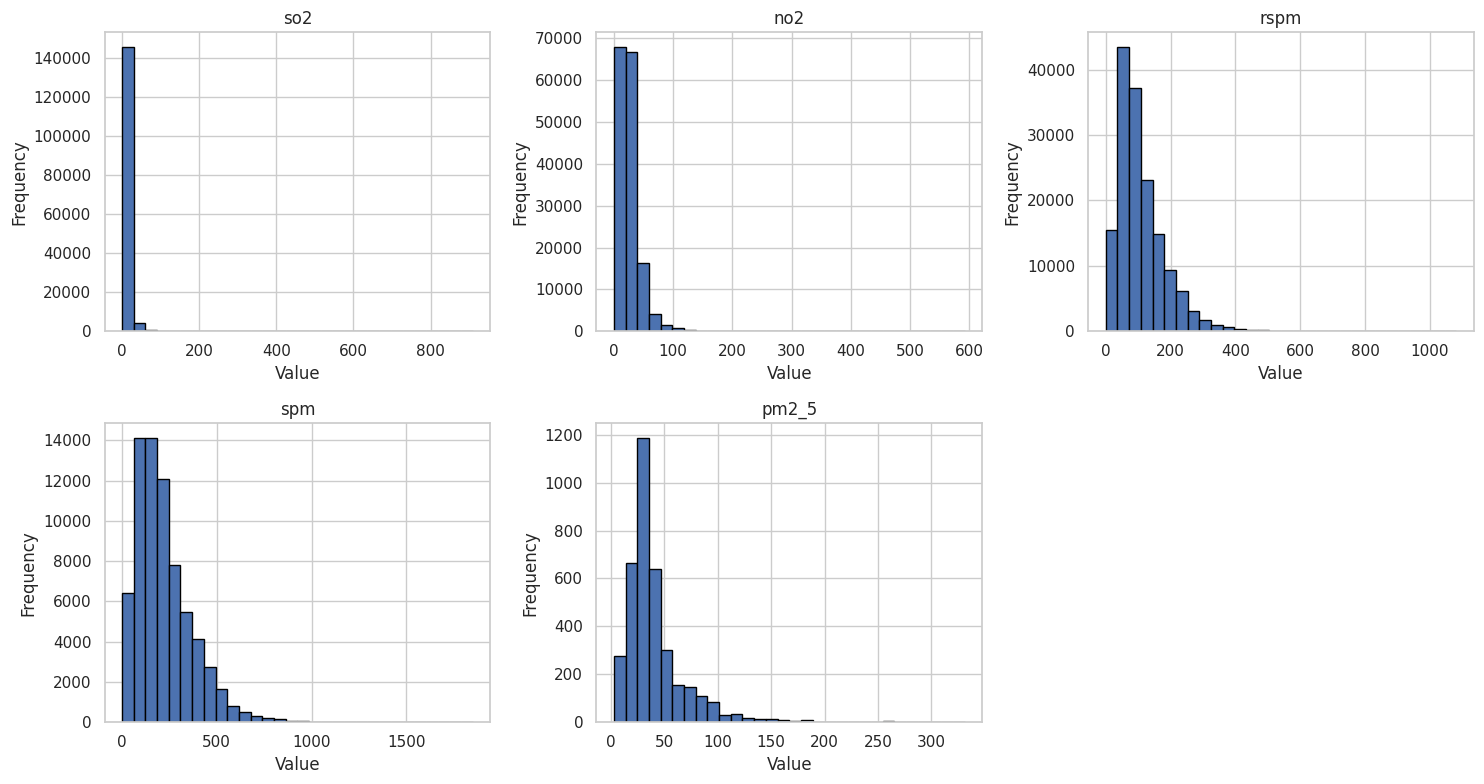

In [404]:
plot_numeric_histograms(air_quality)

# 2. Data PreProcessing

## 2.1. Handeling Missing Values  

In [405]:
# Reset the index to avoid issues with non-unique PeriodIndex
air_quality.reset_index(inplace=True)

In [406]:
# Find the index of the first non-null value in 'rspm'
first_filled_index = air_quality['rspm'].first_valid_index()

# Filter the DataFrame to include only rows from the first filled index onward
air_quality = air_quality.loc[first_filled_index:]

In [407]:
columns_to_interpolate = ['so2','no2','rspm','spm']
fill_missing_values(air_quality, columns_to_interpolate, method='interpolate')


<ipython-input-281-16d0450857bf>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].interpolate(method='linear', inplace=True, limit_direction='both')
<ipython-input-281-16d0450857bf>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

,month,stn_code,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
1001,2003-01,55,Delhi,Delhi,Central Pollution Control Board,Industrial Area,5.0,34.0,149.0,205.0,NaN,NaN,2003-01-01
1002,2003-01,57,Delhi,Delhi,Central Pollution Control Board,Industrial Area,5.0,29.0,101.0,233.0,NaN,NaN,2003-01-01
1003,2003-01,247,Gujarat,Bharuch,Gujarat Pollution Control Board,NaN,0.0,0.0,0.0,0.0,NaN,NaN,2003-01-01
1004,2003-01,248,Gujarat,Bharuch,Gujarat Pollution Control Board,NaN,0.0,0.0,0.0,0.0,NaN,NaN,2003-01-01
1005,2003-01,84,Madhya Pradesh,Nagda,Madhya Pradesh Pollution Control Board,"Residential, Rural and other Areas",0.0,0.0,0.0,0.0,NaN,NaN,2003-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164152,2015-12,SAMP,West Bengal,HALDIA,West Bengal State Pollution Control Board,RIRUO,32.0,65.0,173.0,29.0,"Rooftop of Ruchi Soya,HALDIA",NaN,2015-12-12
164153,2015-12,SAMP,West Bengal,Kolkata,West Bengal State Pollution Control Board,RIRUO,2.0,47.0,95.0,29.0,"Rooftop of Manicktala Fire Station Building,Ul...",NaN,2015-12-12
164154,2015-12,SAMP,West Bengal,MALDAH,West Bengal State Pollution Control Board,RIRUO,2.0,17.0,106.0,29.0,"Rooftop Maldah Regional Office, WBPCB,MALDAH",NaN,2015-12-12
164155,2015-12,SAMP,West Bengal,SILIGURI,West Bengal State Pollution Control Board,RIRUO,4.0,21.0,107.0,29.0,Rooftop of Siliguri Industrial Estate Developm...,NaN,2015-12-12


In [408]:
#Null value located at the begining, we will drop that first row
first_filled_index = air_quality['so2'].first_valid_index()
air_quality = air_quality.loc[first_filled_index:]

In [409]:
if 'month' in air_quality.columns:
    air_quality['month'] = air_quality['month'].dt.to_timestamp()  # Convert Period to Timestamp
    air_quality['month'] = pd.to_datetime(air_quality['month']).dt.to_period('M')  # Re-convert back to Period
    air_quality.set_index('month', inplace=True)

In [410]:
drop_missing_threshold(air_quality, 60)

Dropped columns with >60% missing values: ['pm2_5']


In [411]:
check(air_quality, 5)
missing_summ(air_quality)

stn_code                       57186
agency                         57525
type                              80
location_monitoring_station     1048
dtype: int64


,0
stn_code,57186
agency,57525
type,80
location_monitoring_station,1048


In [412]:
categorical_filling(air_quality, 'type')

Remaining missing values:
 stn_code                       57186
agency                         57525
location_monitoring_station     1048
dtype: int64


<ipython-input-281-f73c071f34c3>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(most_frequent_type, inplace=True)


,stn_code,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,date
month,,,,,,,,,,,
2003-01,55,Delhi,Delhi,Central Pollution Control Board,Industrial Area,5.0,34.0,149.0,205.0,NaN,2003-01-01
2003-01,57,Delhi,Delhi,Central Pollution Control Board,Industrial Area,5.0,29.0,101.0,233.0,NaN,2003-01-01
2003-01,247,Gujarat,Bharuch,Gujarat Pollution Control Board,"Residential, Rural and other Areas",0.0,0.0,0.0,0.0,NaN,2003-01-01
2003-01,248,Gujarat,Bharuch,Gujarat Pollution Control Board,"Residential, Rural and other Areas",0.0,0.0,0.0,0.0,NaN,2003-01-01
2003-01,84,Madhya Pradesh,Nagda,Madhya Pradesh Pollution Control Board,"Residential, Rural and other Areas",0.0,0.0,0.0,0.0,NaN,2003-01-01
...,...,...,...,...,...,...,...,...,...,...,...
2015-12,SAMP,West Bengal,HALDIA,West Bengal State Pollution Control Board,RIRUO,32.0,65.0,173.0,29.0,"Rooftop of Ruchi Soya,HALDIA",2015-12-12
2015-12,SAMP,West Bengal,Kolkata,West Bengal State Pollution Control Board,RIRUO,2.0,47.0,95.0,29.0,"Rooftop of Manicktala Fire Station Building,Ul...",2015-12-12
2015-12,SAMP,West Bengal,MALDAH,West Bengal State Pollution Control Board,RIRUO,2.0,17.0,106.0,29.0,"Rooftop Maldah Regional Office, WBPCB,MALDAH",2015-12-12


In [413]:
columns_to_drop = ['agency','location_monitoring_station','stn_code','state' ]
drop_columns(air_quality, columns_to_drop)
check(air_quality,5)

Dropped columns: ['agency', 'location_monitoring_station', 'stn_code', 'state']


,location,type,so2,no2,rspm,spm,date
month,,,,,,,
2003-01,Delhi,Industrial Area,5.0,34.0,149.0,205.0,2003-01-01
2003-01,Delhi,Industrial Area,5.0,29.0,101.0,233.0,2003-01-01
2003-01,Bharuch,"Residential, Rural and other Areas",0.0,0.0,0.0,0.0,2003-01-01
2003-01,Bharuch,"Residential, Rural and other Areas",0.0,0.0,0.0,0.0,2003-01-01
2003-01,Nagda,"Residential, Rural and other Areas",0.0,0.0,0.0,0.0,2003-01-01


In this step, we have chosen to retain the "location" column and drop the "state" column, even though "state" offers broader regional context. This decision aligns closely with the project's goal of identifying specific, granular trends in air quality across different monitoring sites, which the "location" data supports more effectively.

Our decision to focus on "location" data is guided by the following key considerations:

- **Granular Insights:** Keeping "location" allows us to detect localized trends that may be missed at the state level. Such granularity is crucial for precise monitoring and for addressing environmental issues at the source, such as specific industrial areas or urban centers.

- **Trend Specificity:** Localized data at the "location" level captures site-specific variations that provide a deeper understanding of air quality dynamics, offering insights that can inform targeted policy or health interventions at smaller scales.

- **Consistency in Data Availability:** The "location" data provides sufficient coverage and consistent entries across time periods, making it a reliable choice for trend analysis without the risk of generalizing at too high a level, which might obscure significant variations.
- **Data size:** using location level enables us to keep a bigger data sample for our analysis; a critical element in time series forecasting.

By focusing on "location," we can deliver more detailed and actionable insights in line with our objectives, enabling a focused analysis that captures the complexities and variability of air quality on a local scale.

In [414]:
missing_summ(air_quality)

Series([], dtype: int64)


,0


In [415]:
'''The 3 missing values in Date column are located at the end of the dataset, we will drop the final 7
#unstapled rows. '''
# Drop rows where the 'date' column has NaN values at the end

air_quality = air_quality.iloc[:-7]

In [416]:
missing_summ(air_quality)

Series([], dtype: int64)


,0


## 2.2. Handling Records' Uniformity

In [417]:
# Inspect invalid dates
invalid_dates = air_quality[air_quality['date'].isna()]
if not invalid_dates.empty:
    print("Invalid Dates Detected:", invalid_dates)

# Drop rows with invalid dates
air_quality.dropna(subset=['date'], inplace=True)
air_quality.reset_index(drop=True, inplace=True)

<ipython-input-417-253cd0e253e0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_quality.dropna(subset=['date'], inplace=True)


<ipython-input-281-2724ef037ba4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date_column] = pd.to_datetime(data[date_column], errors='coerce')


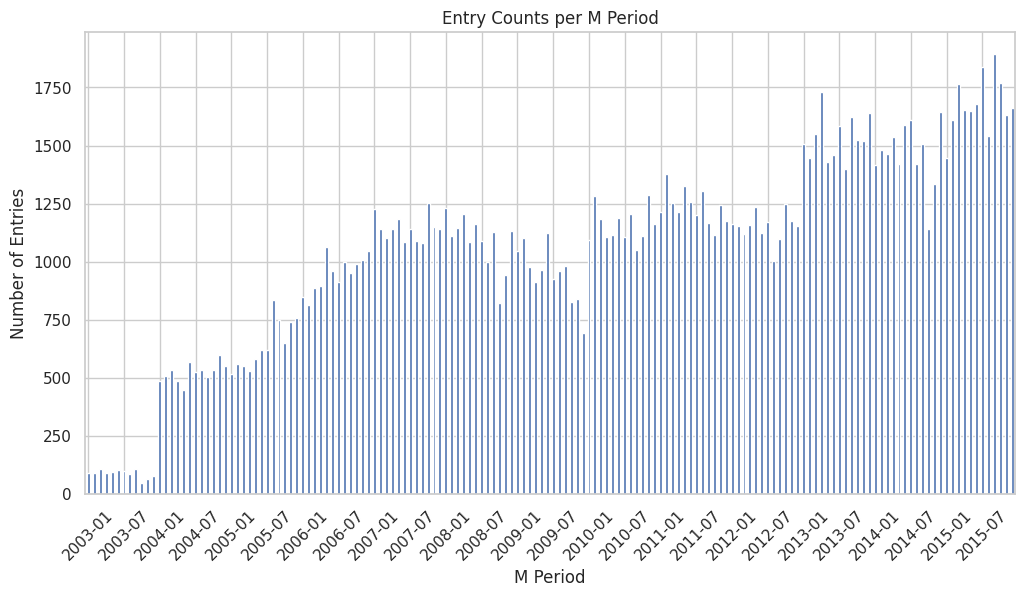

In [418]:
plot_entry_counts(air_quality, date_column='date', period='M')

we will keep more than 1000 entry per month starting 2004-1, and we will only keep entries from locations that are present since that time t = 2004-1

In [419]:
def filter_locations(data, date_column, location_column, start_date):
    """
    Filters the DataFrame to keep only entries from locations that first appeared on a specified start date.

    Parameters:
    - data (DataFrame): The DataFrame containing the data.
    - date_column (str): The name of the date column.
    - location_column (str): The name of the location column.
    - start_date (str): The specified start date in 'YYYY-MM' format.

    Returns:
    - DataFrame: Filtered DataFrame with entries only from locations starting on the specified date.
    """
    # Make a copy of the DataFrame to avoid modifying the original
    data = data.copy()

    # Ensure date column is in datetime format
    data[date_column] = pd.to_datetime(data[date_column], errors='coerce')

    # Convert the start date to datetime
    start_date = pd.to_datetime(start_date)

    # Find the first entry date for each location
    first_entry_dates = data.groupby(location_column)[date_column].min()

    # Identify locations that first appeared on the specified start date
    valid_locations = first_entry_dates[first_entry_dates == start_date].index

    # Filter the data to include only entries from these valid locations
    data_filtered = data[data[location_column].isin(valid_locations)]

    return data_filtered


In [420]:
air_quality = filter_locations(air_quality,'date', 'location','2004-01')

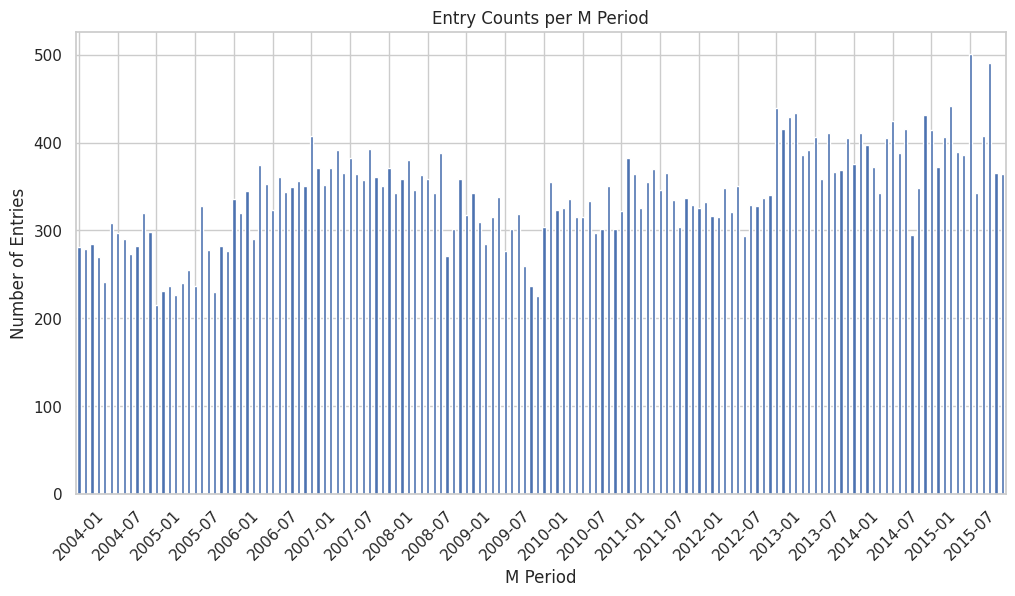

In [421]:
plot_entry_counts(air_quality, date_column='date', period='M')

In [422]:
def filter_single_entry_per_month(data, date_column, location_column, start_date='2004-01', period='M', min_coverage=0.9):
    """
    Filters the DataFrame to keep only one entry per month per location, selecting the first entry for each month.
    Retains only locations that have entries for at least the specified minimum coverage from the start date.

    Parameters:
    - data (DataFrame): The DataFrame containing the data.
    - date_column (str): The name of the date column.
    - location_column (str): The name of the location column.
    - start_date (str): The start date in 'YYYY-MM' format.
    - period (str): The period to group by (e.g., 'M' for month).
    - min_coverage (float): Minimum proportion of months with entries per location (e.g., 0.9 for 90% coverage).

    Returns:
    - DataFrame: Filtered DataFrame with only one entry per month per location.
    """
    # Ensure date column is in datetime format
    data = data.copy()
    data[date_column] = pd.to_datetime(data[date_column], errors='coerce')

    # Filter data to include only entries on or after the specified start date
    start_date = pd.to_datetime(start_date)
    data = data[data[date_column] >= start_date]

    # Generate a period column for monthly grouping
    data['period'] = data[date_column].dt.to_period(period)

    # Group by location and period (month), keeping only the first entry per month for each location
    data = data.groupby([location_column, 'period']).first().reset_index()

    # Generate a full range of periods for the analysis duration
    required_periods = pd.period_range(start=start_date, end=data[date_column].max(), freq=period)
    total_months = len(required_periods)
    complete_entries = []

    for location in data[location_column].unique():
        # Filter data for each location and reindex to align with the full range of periods
        location_data = data[data[location_column] == location].set_index('period').reindex(required_periods)

        # Calculate the proportion of available data points
        coverage = location_data[date_column].notna().mean()

        # Append location data if it meets the minimum coverage threshold
        if coverage >= min_coverage:
            complete_entries.append(location_data.reset_index())

    # Concatenate the valid locations back into a single DataFrame
    if complete_entries:
        filtered_data = pd.concat(complete_entries).reset_index(drop=True)
        # Drop the 'period' column if it exists
        filtered_data = filtered_data.drop(columns=['period'], errors='ignore')
    else:
        filtered_data = pd.DataFrame(columns=data.columns)

    return filtered_data



Explanation

**Reindexing by Required Periods:** We reindex each location's data to ensure alignment with the full range of monthly periods from the start_date to the latest date in the data.

**Calculating Coverage:** For each location, we calculate the proportion of non-null entries in date_column after reindexing, representing the data completeness.

**Filtering by Minimum Coverage:** Only locations with coverage meeting or exceeding min_coverage are included in the final output.


In [423]:
air_quality = filter_single_entry_per_month(air_quality, 'date', 'location', start_date='2004-01', period='M', min_coverage = 0.8)

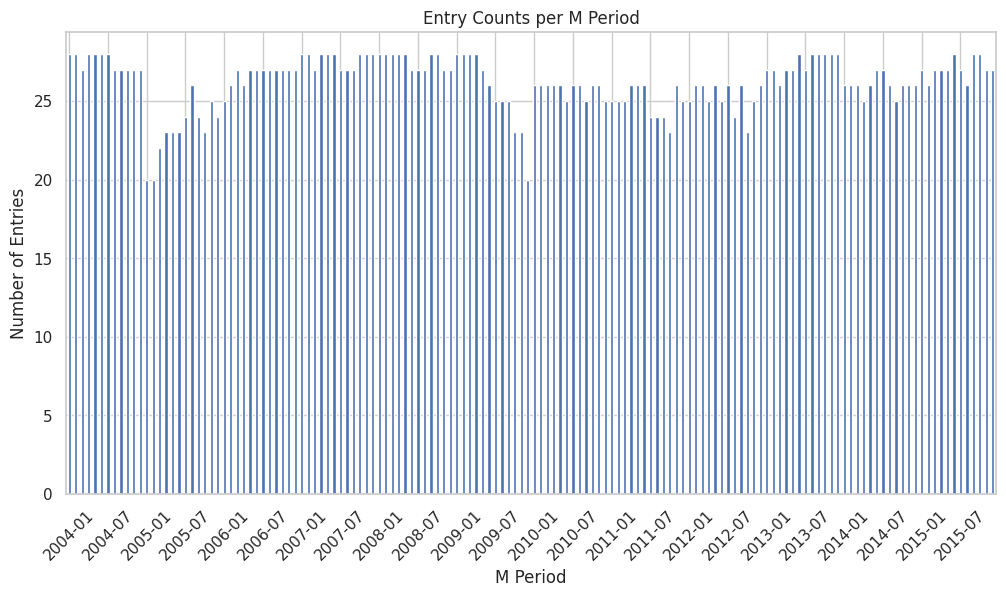

In [424]:
plot_entry_counts(air_quality, date_column='date', period='M')

we set a coverage treshold = 80% because producing a 100% uniformity level results in a very small data set of 720 entry. Thus we will tolerate a certain level of fluctuation especially in our case when dealing environmental data,like air quality and meteorological data, often have irregularities due to logistical issues, equipment downtime, or data reporting delays. Minor gaps and variations are expected and do not automatically invalidate the data's usability for analysis.\

**Forecasting Models:** Many time series models, such as ARIMA or seasonal models, can handle minor gaps or variations in the data without significant loss of accuracy. Machine learning models, like LSTM, can also tolerate some variability as long as the gaps aren’t too frequent or concentrated in critical periods.

**Seasonality & Trends:** If the dataset has high coverage and the gaps are not systematic, models can still capture the main seasonal patterns and trends. Missing a few data points here and there generally won’t disrupt the model's ability to recognize these patterns.

In [425]:
check(air_quality,10)

,index,location,type,so2,no2,rspm,spm,date
0,2004-01,Agra,"Residential, Rural and other Areas",9.0,10.0,183.0,10.0,2004-01-01
1,2004-02,Agra,Industrial Area,7.2,7.7,86.0,7.0,2004-02-03
2,2004-03,Agra,"Residential, Rural and other Areas",8.7,6.9,115.5,8.0,2004-03-01
3,2004-04,Agra,"Residential, Rural and other Areas",7.8,6.5,157.5,7.0,2004-04-01
4,2004-05,Agra,Industrial Area,6.8,8.0,178.0,7.0,2004-05-07
5,2004-06,Agra,Industrial Area,6.8,6.2,110.0,7.0,2004-06-01
6,2004-07,Agra,"Residential, Rural and other Areas",7.5,5.3,71.0,6.0,2004-07-01
7,2004-08,Agra,"Residential, Rural and other Areas",17.5,4.5,115.5,5.0,2004-08-02
8,2004-09,Agra,"Residential, Rural and other Areas",7.0,8.6,151.0,56.0,2004-09-02
9,2004-10,Agra,Industrial Area,7.0,6.7,247.0,87.0,2004-10-01


In [426]:
size(air_quality)

(4032, 8)

## 2.3. Date & Time Standardization

In [427]:
def standardize_date_index(data, date_column):
    """
    Standardizes the date column to datetime and sets it as a PeriodIndex (monthly).

    Parameters:
    - data (DataFrame): The DataFrame to process.
    - date_column (str): The name of the date column to standardize.

    Returns:
    - DataFrame: Updated DataFrame with standardized date column and set index.
    """
    # Convert the date column to datetime
    data[date_column] = pd.to_datetime(data[date_column], errors='coerce')
    # Drop rows with invalid dates
    data = data.dropna(subset=[date_column])
    # Add a 'month' PeriodIndex for indexing
    data['month'] = data[date_column].dt.to_period('M')
    # Keep both the 'date' column and the 'month' index
    data.set_index('month', inplace=True)
    return data

Explanation

**Convert the Date Column:** Ensures that the date column is in datetime format.

**Remove Unparseable Dates:** Drops any rows where the date couldn't be parsed.

**Set Date as Index:** Sets the date column as the DataFrame index.

**Drop the Original Date Column:** Removes the original date column after setting it as the index.

In [428]:
air_quality = standardize_date_index(air_quality, 'date')

<ipython-input-427-00f34974f359>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data[date_column].dt.to_period('M')


In [429]:
columns_to_drop = ['index','date']
drop_columns(air_quality, columns_to_drop)

Dropped columns: ['index', 'date']


<ipython-input-281-14b6cbac3a8f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=columns_to_drop, inplace=True)


In [430]:
check(air_quality, 5)

,location,type,so2,no2,rspm,spm
month,,,,,,
2004-01,Agra,"Residential, Rural and other Areas",9.0,10.0,183.0,10.0
2004-02,Agra,Industrial Area,7.2,7.7,86.0,7.0
2004-03,Agra,"Residential, Rural and other Areas",8.7,6.9,115.5,8.0
2004-04,Agra,"Residential, Rural and other Areas",7.8,6.5,157.5,7.0
2004-05,Agra,Industrial Area,6.8,8.0,178.0,7.0


## 2.4. Outliers Detection & Treatment

In [431]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [432]:
def plot_boxplots(data, numerical_columns):
    """
    Plots boxplots for each numerical column to visualize outliers.
    """
    for col in numerical_columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=data[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

**Outlier Detection Method:** The IQR method is widely used for detecting outliers because it’s robust against extreme values and is less affected by skewed distributions than methods like standard deviation. Additionally, it’s straightforward to implement and interpret, making it a reliable choice for this dataset.

**1.5 Treshold:** This is the conventional threshold in statistics for identifying outliers. Observations beyond 1.5 times the IQR above the 75th percentile (Q3) or below the 25th percentile (Q1) are generally considered outliers. This threshold captures extreme values without being overly restrictive, which would risk excluding valid data points.

**Outlier Removal Choice:** Capping, Replacing outliers with the nearest boundary (lower or upper bound), was chosen as the default method to avoid data loss, which can be problematic, especially in time series where gaps can present a critical problem. This allows us to manage outliers without diminishing the sample size or potentially affecting the dataset’s distribution.

Initial Outlier Visualization:


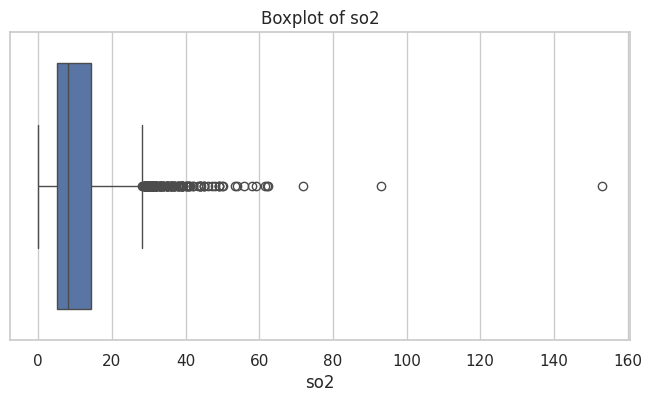

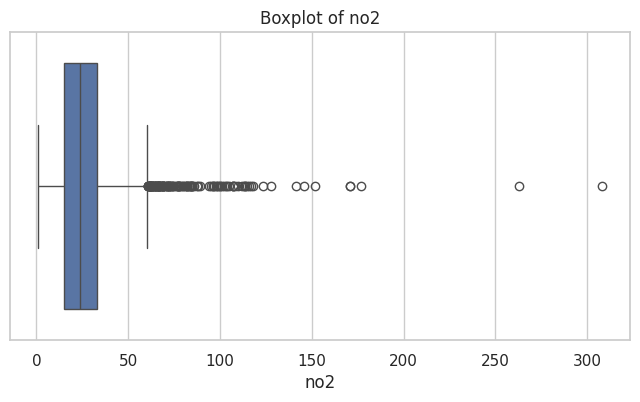

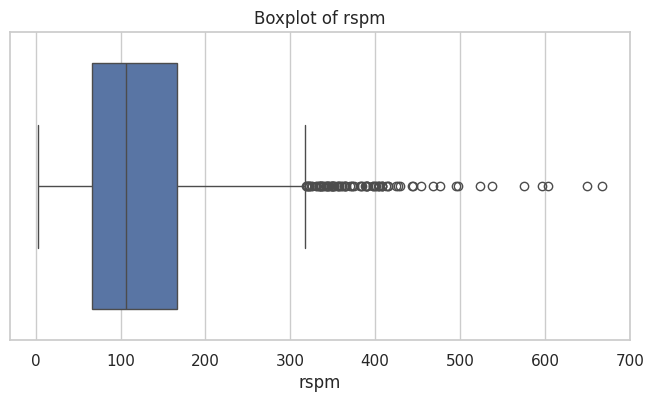

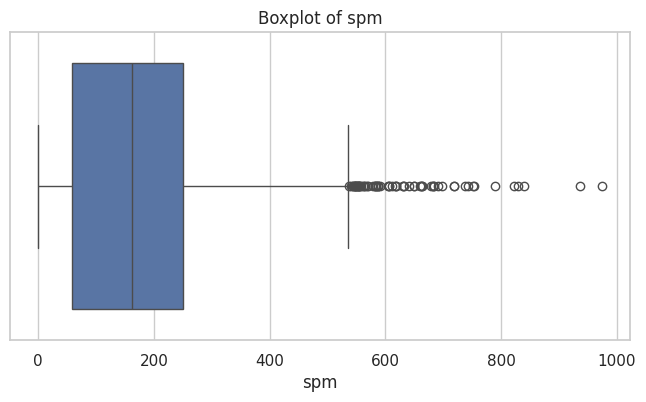

In [433]:
# List of numerical columns in air_quality dataset
numerical_columns = air_quality.select_dtypes(include=['float64', 'int64']).columns

# Initial Outlier Visualization
print("Initial Outlier Visualization:")
plot_boxplots(air_quality, numerical_columns)

In [434]:
# Handle outliers by either capping or removing
# 'cap' method caps outliers at the IQR bounds; 'remove' method removes outlier rows
air_quality = handle_outliers(air_quality, numerical_columns, method='cap')

Outlier Visualization After Handling:


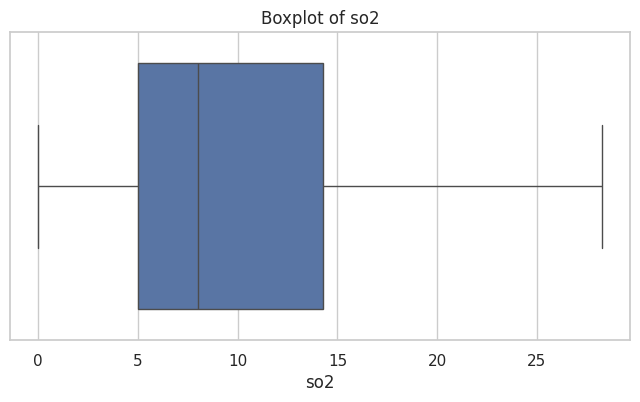

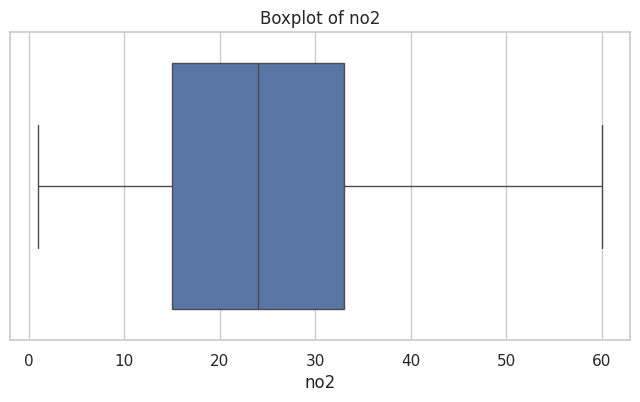

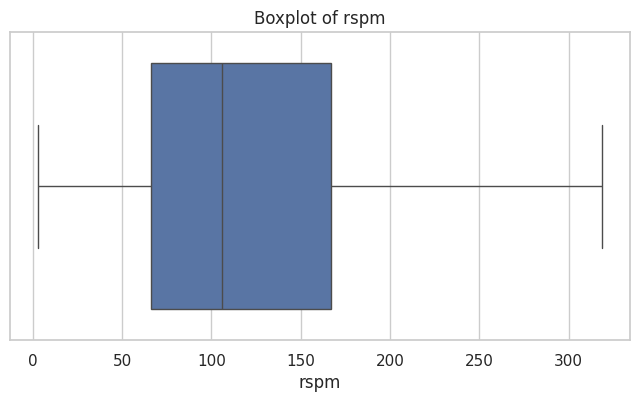

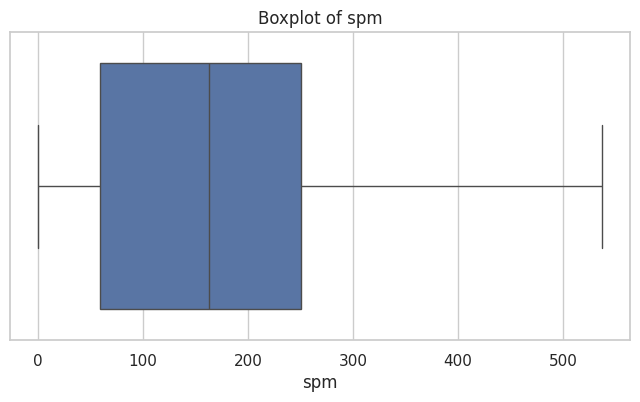

In [435]:
# Outlier Visualization After Handling
print("Outlier Visualization After Handling:")
plot_boxplots(air_quality, numerical_columns)

## 2.5. Data Transformation

### 2.5.1 Categorical Variables Transformation

In [436]:
# List of categorical columns in the dataset
categorical_columns = air_quality.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_columns)

Categorical Columns: Index(['location', 'type'], dtype='object')


**Decision to Encode Categorical Variables:** Many machine learning algorithms require numerical input, so categorical variables need to be transformed. There are two common approaches: One-Hot Encoding and Label Encoding. For this project, I considered the following factors:

One-Hot Encoding is suitable when categories are non-ordinal and don’t have a natural order, as it prevents the model from assuming any rank or hierarchy. This approach is often used for nominal variables and introduces a new binary column for each unique category in the feature.
Label Encoding assigns integer values to categories, making it more compact but potentially introducing unintended ordinal relationships.
I opted for One-Hot Encoding as it is more suitable for categorical features that don't have a natural order, preventing bias toward any particular category.
Handling High Cardinality: One-Hot Encoding can result in a large number of columns if there are numerous unique categories, which increases computational cost and memory usage. To avoid this:

I applied One-Hot Encoding selectively to features with a manageable number of categories.
For variables with high cardinality, alternative encoding techniques or dimensionality reduction would be considered in larger datasets, but for this dataset, One-Hot Encoding is feasible.

In [437]:
def transform_categorical(data, columns):
    """
    Transforms specified categorical columns in the DataFrame into one-hot encoded (dummy) variables
    with numeric values (0 and 1).

    Parameters:
    - data (DataFrame): The DataFrame containing the data.
    - columns (list): List of columns to be One-Hot Encoded.

    Returns:
    - DataFrame: Transformed DataFrame with dummy variables as integers for specified categorical columns.
    """
    # Exclude date columns from transformation
    columns = [col for col in columns if not pd.api.types.is_datetime64_any_dtype(data[col])]

    # Apply One-Hot Encoding
    data = pd.get_dummies(data, columns=columns, drop_first=True)

    # Ensure all dummy columns are strictly integers (0/1)
    dummy_columns = data.columns.difference(columns)
    data[dummy_columns] = data[dummy_columns].astype(int)

    return data




**Explanation for Drop-First Parameter:** The drop_first=True parameter in One-Hot Encoding was used to avoid multicollinearity by dropping one category from each encoded feature. This prevents redundant data and ensures that the encoded columns are not linearly dependent, which can improve model performance.

**Review and Validation of Transformation:** After transformation, we will check the dataset to ensure that all selected categorical variables were encoded correctly and that there were no issues with column names or values. This step is crucial to ensure consistency in the transformed dataset and that it aligns with the rest of the preprocessing pipeline.

In [438]:
for col in categorical_columns:
    print(f"Column: {col}, Unique Values: {air_quality[col].unique()}")
categorical_columns = air_quality.select_dtypes(exclude=['number']).columns.tolist()
print(categorical_columns)


Column: location, Unique Values: ['Agra' 'Alwar' 'Bangalore' 'Chandigarh' 'Coimbatore' 'Damtal' 'Ghaziabad'
 'Gobindgarh' 'Jalandhar' 'Jamnagar' 'Jodhpur' 'Kanpur' 'Kolkata' 'Kota'
 'Lucknow' 'Mumbai' 'Nashik' 'Paonta Sahib' 'Parwanoo' 'Pondicherry'
 'Pune' 'Rourkela' 'Shimla' 'Solapur' 'Thane' 'Udaipur' 'Varanasi'
 'Visakhapatnam']
Column: type, Unique Values: ['Residential, Rural and other Areas' 'Industrial Area'
 'Residential and others' 'Industrial Areas' 'Sensitive Areas'
 'Sensitive Area']
['location', 'type']


In [439]:
check(air_quality, 20)

,location,type,so2,no2,rspm,spm
month,,,,,,
2004-01,Agra,"Residential, Rural and other Areas",9.0,10.00,183.0,10.000000
2004-02,Agra,Industrial Area,7.2,7.70,86.0,7.000000
2004-03,Agra,"Residential, Rural and other Areas",8.7,6.90,115.5,8.000000
2004-04,Agra,"Residential, Rural and other Areas",7.8,6.50,157.5,7.000000
2004-05,Agra,Industrial Area,6.8,8.00,178.0,7.000000
2004-06,Agra,Industrial Area,6.8,6.20,110.0,7.000000
2004-07,Agra,"Residential, Rural and other Areas",7.5,5.30,71.0,6.000000
2004-08,Agra,"Residential, Rural and other Areas",17.5,4.50,115.5,5.000000
2004-09,Agra,"Residential, Rural and other Areas",7.0,8.60,151.0,56.000000


In [440]:
categorical_columns = ['location', 'type']
air_quality = transform_categorical(air_quality, categorical_columns)

# Validate transformation
print("Transformed DataFrame Columns:", air_quality.columns)


Transformed DataFrame Columns: Index(['so2', 'no2', 'rspm', 'spm', 'location_Alwar', 'location_Bangalore',
       'location_Chandigarh', 'location_Coimbatore', 'location_Damtal',
       'location_Ghaziabad', 'location_Gobindgarh', 'location_Jalandhar',
       'location_Jamnagar', 'location_Jodhpur', 'location_Kanpur',
       'location_Kolkata', 'location_Kota', 'location_Lucknow',
       'location_Mumbai', 'location_Nashik', 'location_Paonta Sahib',
       'location_Parwanoo', 'location_Pondicherry', 'location_Pune',
       'location_Rourkela', 'location_Shimla', 'location_Solapur',
       'location_Thane', 'location_Udaipur', 'location_Varanasi',
       'location_Visakhapatnam', 'type_Industrial Areas',
       'type_Residential and others',
       'type_Residential, Rural and other Areas', 'type_Sensitive Area',
       'type_Sensitive Areas'],
      dtype='object')


In [441]:
air_quality.describe(include='all')

,so2,no2,rspm,spm,location_Alwar,location_Bangalore,location_Chandigarh,location_Coimbatore,location_Damtal,location_Ghaziabad,...,location_Solapur,location_Thane,location_Udaipur,location_Varanasi,location_Visakhapatnam,type_Industrial Areas,type_Residential and others,"type_Residential, Rural and other Areas",type_Sensitive Area,type_Sensitive Areas
count,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,...,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000
mean,10.181288,25.359661,122.604824,177.142327,0.034985,0.034985,0.037901,0.035250,0.035516,0.036576,...,0.037901,0.037371,0.037636,0.032335,0.030745,0.173072,0.224755,0.360456,0.028889,0.017228
std,7.230965,13.173660,72.707953,133.627518,0.183767,0.183767,0.190982,0.184437,0.185103,0.187742,...,0.190982,0.189694,0.190339,0.176912,0.172648,0.378360,0.417476,0.480196,0.167518,0.130136
min,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,15.000000,66.000000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,24.000000,106.000000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.000000,33.000000,167.000000,250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,28.000000,60.000000,318.000000,536.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [442]:
check(air_quality,50)

,so2,no2,rspm,spm,location_Alwar,location_Bangalore,location_Chandigarh,location_Coimbatore,location_Damtal,location_Ghaziabad,...,location_Solapur,location_Thane,location_Udaipur,location_Varanasi,location_Visakhapatnam,type_Industrial Areas,type_Residential and others,"type_Residential, Rural and other Areas",type_Sensitive Area,type_Sensitive Areas
month,,,,,,,,,,,,,,,,,,,,,
2004-01,9,10,183,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2004-02,7,7,86,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2004-03,8,6,115,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2004-04,7,6,157,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2004-05,6,8,178,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2004-06,6,6,110,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2004-07,7,5,71,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2004-08,17,4,115,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2004-09,7,8,151,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [443]:
print(air_quality.columns)

Index(['so2', 'no2', 'rspm', 'spm', 'location_Alwar', 'location_Bangalore',
       'location_Chandigarh', 'location_Coimbatore', 'location_Damtal',
       'location_Ghaziabad', 'location_Gobindgarh', 'location_Jalandhar',
       'location_Jamnagar', 'location_Jodhpur', 'location_Kanpur',
       'location_Kolkata', 'location_Kota', 'location_Lucknow',
       'location_Mumbai', 'location_Nashik', 'location_Paonta Sahib',
       'location_Parwanoo', 'location_Pondicherry', 'location_Pune',
       'location_Rourkela', 'location_Shimla', 'location_Solapur',
       'location_Thane', 'location_Udaipur', 'location_Varanasi',
       'location_Visakhapatnam', 'type_Industrial Areas',
       'type_Residential and others',
       'type_Residential, Rural and other Areas', 'type_Sensitive Area',
       'type_Sensitive Areas'],
      dtype='object')


**Noticed Redundant Categorical Variables**
In the dummy variables, `type` has redundant categories:
- `type_Sensitive Area` and `type_Sensitive Areas` should be combined.
- `type_Residential and others` and `type_Residential, Rural and other Areas` should also be combined.

**Solution**
I’ll merge these similar categories to remove redundancy and reduce noise. This will simplify the dataset and improve feature quality.

In [444]:
# Combining similar categories for 'type' dummy variables
# Step 1: Create a new column that combines the values for 'Sensitive Areas' and 'Residential'
air_quality['type_Sensitive'] = air_quality[['type_Sensitive Area', 'type_Sensitive Areas']].max(axis=1)
air_quality['type_Residential'] = air_quality[['type_Residential and others', 'type_Residential, Rural and other Areas']].max(axis=1)

# Step 2: Drop the original redundant columns
air_quality.drop(columns=['type_Sensitive Area', 'type_Sensitive Areas',
                          'type_Residential and others', 'type_Residential, Rural and other Areas'], inplace=True)

# Confirm the changes
print("Updated columns after combining similar categories:")
print(air_quality.columns)

Updated columns after combining similar categories:
Index(['so2', 'no2', 'rspm', 'spm', 'location_Alwar', 'location_Bangalore',
       'location_Chandigarh', 'location_Coimbatore', 'location_Damtal',
       'location_Ghaziabad', 'location_Gobindgarh', 'location_Jalandhar',
       'location_Jamnagar', 'location_Jodhpur', 'location_Kanpur',
       'location_Kolkata', 'location_Kota', 'location_Lucknow',
       'location_Mumbai', 'location_Nashik', 'location_Paonta Sahib',
       'location_Parwanoo', 'location_Pondicherry', 'location_Pune',
       'location_Rourkela', 'location_Shimla', 'location_Solapur',
       'location_Thane', 'location_Udaipur', 'location_Varanasi',
       'location_Visakhapatnam', 'type_Industrial Areas', 'type_Sensitive',
       'type_Residential'],
      dtype='object')


## 2.5.2 Feature Correlation Analysis

To reduce redundancy and improve model interpretability, I’ll begin with a collinearity analysis. By identifying and removing features with high correlation, I aim to stabilize the model and ensure that it isn’t influenced by duplicate information.

In this step, I examined correlations between numerical features to identify pairs with high collinearity (absolute correlation > 0.8). Dropping or aggregating these features will improve model interpretability and prevent unstable model coefficients.

In [445]:
valuable_columns = ['so2', 'no2', 'rspm', 'spm']

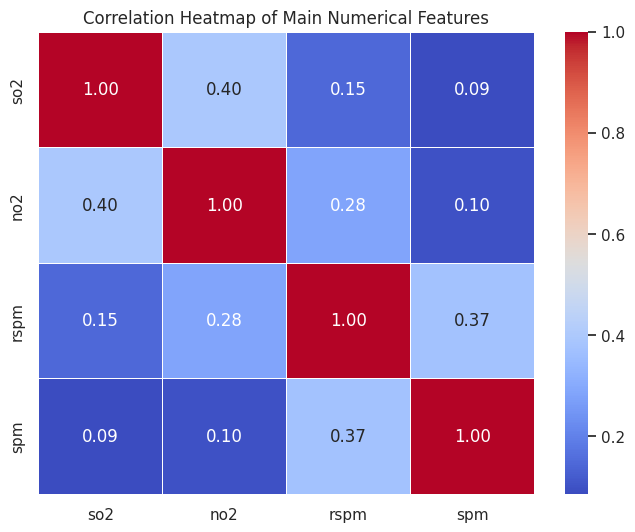

Highly Correlated Pairs: []


In [446]:
# Calculate correlation matrix for selected numerical features
correlation_matrix = air_quality[valuable_columns].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Main Numerical Features")
plt.show()

# Identify highly correlated features (absolute correlation > 0.8) among main numerical columns
high_corr_pairs = [(col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns
                   if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.8]
print("Highly Correlated Pairs:", high_corr_pairs)

There is no presence of multicolinearity in this dataset

## 2.5.3 Feature Engineering

### Creating Interaction Features

In this section, I will create interaction features for pairs of variables that could reveal non-linear relationships or capture meaningful patterns. Interaction features help the model identify complex relationships that may be present in the data.

In this approach, I created interaction features among the predictor variables SO2, NO2, and RSPM. These interactions aim to capture compound relationships that might influence SPM indirectly. By evaluating correlations with SPM and visualizing these interactions, I will be able to identify if any interactions offer added predictive value, helping to optimize model accuracy.

Correlation of interaction features with SPM:
 so2_no2_interaction     0.069294
so2_rspm_interaction    0.260009
no2_rspm_interaction    0.257081
Name: spm, dtype: float64


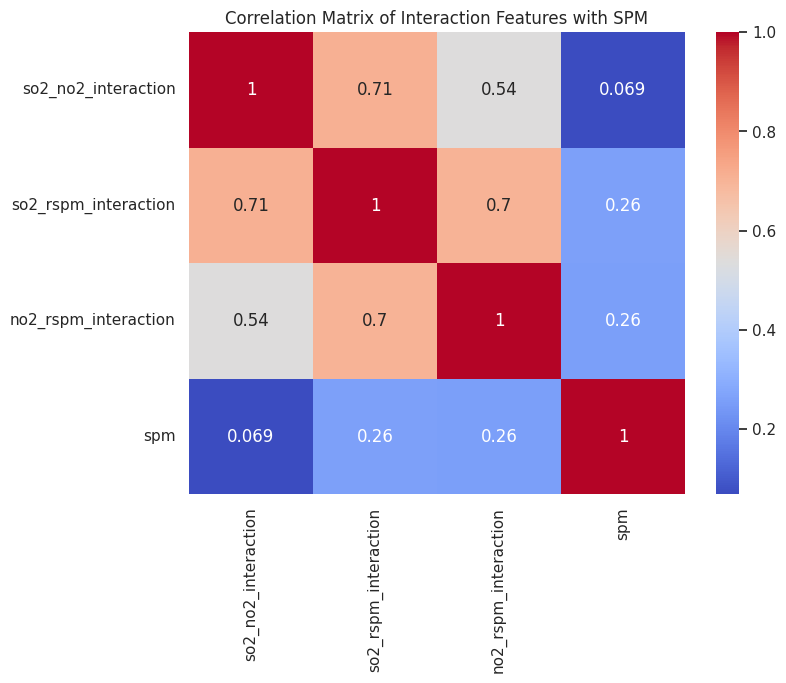

In [447]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Generate interaction features (excluding SPM)
air_quality['so2_no2_interaction'] = air_quality['so2'] * air_quality['no2']
air_quality['so2_rspm_interaction'] = air_quality['so2'] * air_quality['rspm']
air_quality['no2_rspm_interaction'] = air_quality['no2'] * air_quality['rspm']

# Step 2: Correlation analysis with target (SPM)
interaction_features = ['so2_no2_interaction', 'so2_rspm_interaction', 'no2_rspm_interaction']
correlations = air_quality[interaction_features + ['spm']].corr()['spm'].drop('spm')
print("Correlation of interaction features with SPM:\n", correlations)

# Step 3: Visualization of Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(air_quality[interaction_features + ['spm']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Interaction Features with SPM")
plt.show()

**Results Interpretation:**

This correlation matrix analysis has guided the selection of interaction features to retain. no2_rspm_interaction and so2_rspm_interaction are retained due to their moderate association with SPM, while so2_no2_interaction will be excluded to streamline the model and avoid redundancy. This approach ensures that we focus on interaction terms that are more likely to contribute meaningful information to the prediction of SPM.

In [448]:
# Dropping the interaction feature with low correlation to SPM
columns_to_drop = ['so2_no2_interaction']  # This feature showed minimal correlation with SPM
air_quality.drop(columns=columns_to_drop, inplace=True)

# Display remaining columns to confirm
print("Remaining columns after dropping irrelevant interaction features:")
print(air_quality.columns)

Remaining columns after dropping irrelevant interaction features:
Index(['so2', 'no2', 'rspm', 'spm', 'location_Alwar', 'location_Bangalore',
       'location_Chandigarh', 'location_Coimbatore', 'location_Damtal',
       'location_Ghaziabad', 'location_Gobindgarh', 'location_Jalandhar',
       'location_Jamnagar', 'location_Jodhpur', 'location_Kanpur',
       'location_Kolkata', 'location_Kota', 'location_Lucknow',
       'location_Mumbai', 'location_Nashik', 'location_Paonta Sahib',
       'location_Parwanoo', 'location_Pondicherry', 'location_Pune',
       'location_Rourkela', 'location_Shimla', 'location_Solapur',
       'location_Thane', 'location_Udaipur', 'location_Varanasi',
       'location_Visakhapatnam', 'type_Industrial Areas', 'type_Sensitive',
       'type_Residential', 'so2_rspm_interaction', 'no2_rspm_interaction'],
      dtype='object')


### 2.5.4 Extractive Date-Time Features

In [449]:
# Extracting date-based features
air_quality['year'] = air_quality.index.year
air_quality['month'] = air_quality.index.month

# Adding seasonal indicators
air_quality['is_winter'] = air_quality['month'].isin([12, 1, 2]).astype(int)  # Winter: December, January, February
air_quality['is_spring'] = air_quality['month'].isin([3, 4, 5]).astype(int)   # Spring: March, April, May
air_quality['is_summer'] = air_quality['month'].isin([6, 7, 8]).astype(int)   # Summer: June, July, August
air_quality['is_autumn'] = air_quality['month'].isin([9, 10, 11]).astype(int) # Autumn: September, October, November

print("Extracted date-time features: ['year', 'month', 'is_winter', 'is_spring', 'is_summer', 'is_autumn']")



Extracted date-time features: ['year', 'month', 'is_winter', 'is_spring', 'is_summer', 'is_autumn']


In this step, I added new date-time and seasonal features to the dataset to enhance temporal pattern detection in the analysis. Here’s an overview of the features created:

1. **Year and Month Extraction**:
   - Created `year` and `month` columns by extracting these components from the date index.
   - This allows for examining trends over years and changes on a monthly basis. Tracking by year and month helps us observe long-term trends and potential monthly patterns, which could indicate regular changes or cycles in air quality.

2. **Seasonal Indicators**:
   - Added four binary seasonal columns: `is_winter`, `is_spring`, `is_summer`, and `is_autumn`.
   - Each row has a value of 1 for the season it falls in, while other seasons are set to 0.
   - This enables the analysis to detect whether pollution levels or patterns are affected by seasonal changes. Certain pollutants may increase in specific seasons, and these indicators allow the model to account for these seasonal variations directly.

##### Purpose
By including `year`, `month`, and seasonal indicators (`is_winter`, `is_spring`, `is_summer`, `is_autumn`), I am enabling the model to capture **temporal patterns** and **seasonal effects**. This breakdown is critical to observe and potentially mitigate seasonal air quality trends, as it allows us to determine if certain seasons have higher pollution levels. These features support the goal of capturing longer-term dynamics in air quality over time.




### 2.5.5 Creating Aggregated or Rolling Features

In [450]:
# Creating rolling averages for smoother trend analysis
air_quality['so2_3month_avg'] = air_quality['so2'].rolling(window=3).mean()
air_quality['no2_3month_avg'] = air_quality['no2'].rolling(window=3).mean()
air_quality['rspm_3month_avg'] = air_quality['rspm'].rolling(window=3).mean()

print("Created rolling features: ['so2_3month_avg', 'no2_3month_avg', 'rspm_3month_avg']")

Created rolling features: ['so2_3month_avg', 'no2_3month_avg', 'rspm_3month_avg']


In [451]:
missing_summ(air_quality)

so2_3month_avg     2
no2_3month_avg     2
rspm_3month_avg    2
dtype: int64


,0
so2_3month_avg,2
no2_3month_avg,2
rspm_3month_avg,2


In [452]:
columns_to_interpolate = ['so2_3month_avg','no2_3month_avg','rspm_3month_avg']
fill_missing_values(air_quality, columns_to_interpolate, method='interpolate')

<ipython-input-281-16d0450857bf>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].interpolate(method='linear', inplace=True, limit_direction='both')
<ipython-input-281-16d0450857bf>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

,so2,no2,rspm,spm,location_Alwar,location_Bangalore,location_Chandigarh,location_Coimbatore,location_Damtal,location_Ghaziabad,...,no2_rspm_interaction,year,month,is_winter,is_spring,is_summer,is_autumn,so2_3month_avg,no2_3month_avg,rspm_3month_avg
month,,,,,,,,,,,,,,,,,,,,,
2004-01,9,10,183,10,0,0,0,0,0,0,...,1830,2004,1,1,0,0,0,8.000000,7.666667,128.000000
2004-02,7,7,86,7,0,0,0,0,0,0,...,602,2004,2,1,0,0,0,8.000000,7.666667,128.000000
2004-03,8,6,115,8,0,0,0,0,0,0,...,690,2004,3,0,1,0,0,8.000000,7.666667,128.000000
2004-04,7,6,157,7,0,0,0,0,0,0,...,942,2004,4,0,1,0,0,7.333333,6.333333,119.333333
2004-05,6,8,178,7,0,0,0,0,0,0,...,1424,2004,5,0,1,0,0,7.000000,6.666667,150.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07,9,15,29,29,0,0,0,0,0,0,...,435,2015,7,0,0,1,0,10.666667,20.333333,55.000000
2015-09,12,28,91,29,0,0,0,0,0,0,...,2548,2015,9,0,0,0,1,9.666667,22.333333,74.000000
2015-10,7,17,78,29,0,0,0,0,0,0,...,1326,2015,10,0,0,0,1,9.333333,20.000000,66.000000


In [453]:
missing_summ(air_quality)

Series([], dtype: int64)


,0


**Documentation:**

Created 3-month rolling averages for so2, rspm and no2 to smooth out short-term fluctuations, focusing on sustained trends in air quality metrics.

Applying a 3-month rolling average to so2, rspm and no2 reduces noise and highlights persistent trends, which is beneficial for stable and reliable trend analysis in time series data.

### 2.5.6 Feature Scaling

In [454]:
# Step 5: Scaling Numerical Features

# Explanation: Standardizing numerical features ensures consistency across feature contributions, especially beneficial in models that are sensitive to scale.

from sklearn.preprocessing import StandardScaler

# Selecting numerical columns to scale (excluding one-hot encoded dummies)
numerical_columns = ['so2', 'no2', 'rspm', 'spm', 'so2_rspm_interaction', 'no2_rspm_interaction', 'so2_3month_avg', 'no2_3month_avg','rspm_3month_avg']
scaler = StandardScaler()
air_quality[numerical_columns] = scaler.fit_transform(air_quality[numerical_columns])

print("Scaled numerical features")


Scaled numerical features


Based on our exploratory analysis we noticed that our metric values are not standardized in terms of scale therefore we will be scaling all of them to ensure they are on a similar scale, preventing features with larger ranges from disproportionately influencing the model.

Scaling the numerical features helps maintain balance in the model, ensuring that each feature contributes appropriately to predictions without being affected by varying scales.

# 3. Final Data Inspection

By reviewing the dataset’s final structure and visualizing feature distributions, I ensured that
the data is properly prepared for modeling. Saving this final version allows for consistent and streamlined
loading for future steps.

In [455]:
# Final Data Overview and Summary

print("Dataset Structure and Data Types:")
air_quality.info()
print("\nSummary Statistics of Numerical Features:")
print(air_quality.describe().T)

Dataset Structure and Data Types:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 3773 entries, 2004-01 to 2015-12
Freq: M
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   so2                     3773 non-null   float64
 1   no2                     3773 non-null   float64
 2   rspm                    3773 non-null   float64
 3   spm                     3773 non-null   float64
 4   location_Alwar          3773 non-null   int64  
 5   location_Bangalore      3773 non-null   int64  
 6   location_Chandigarh     3773 non-null   int64  
 7   location_Coimbatore     3773 non-null   int64  
 8   location_Damtal         3773 non-null   int64  
 9   location_Ghaziabad      3773 non-null   int64  
 10  location_Gobindgarh     3773 non-null   int64  
 11  location_Jalandhar      3773 non-null   int64  
 12  location_Jamnagar       3773 non-null   int64  
 13  location_Jodhpur        3773 non-null   i

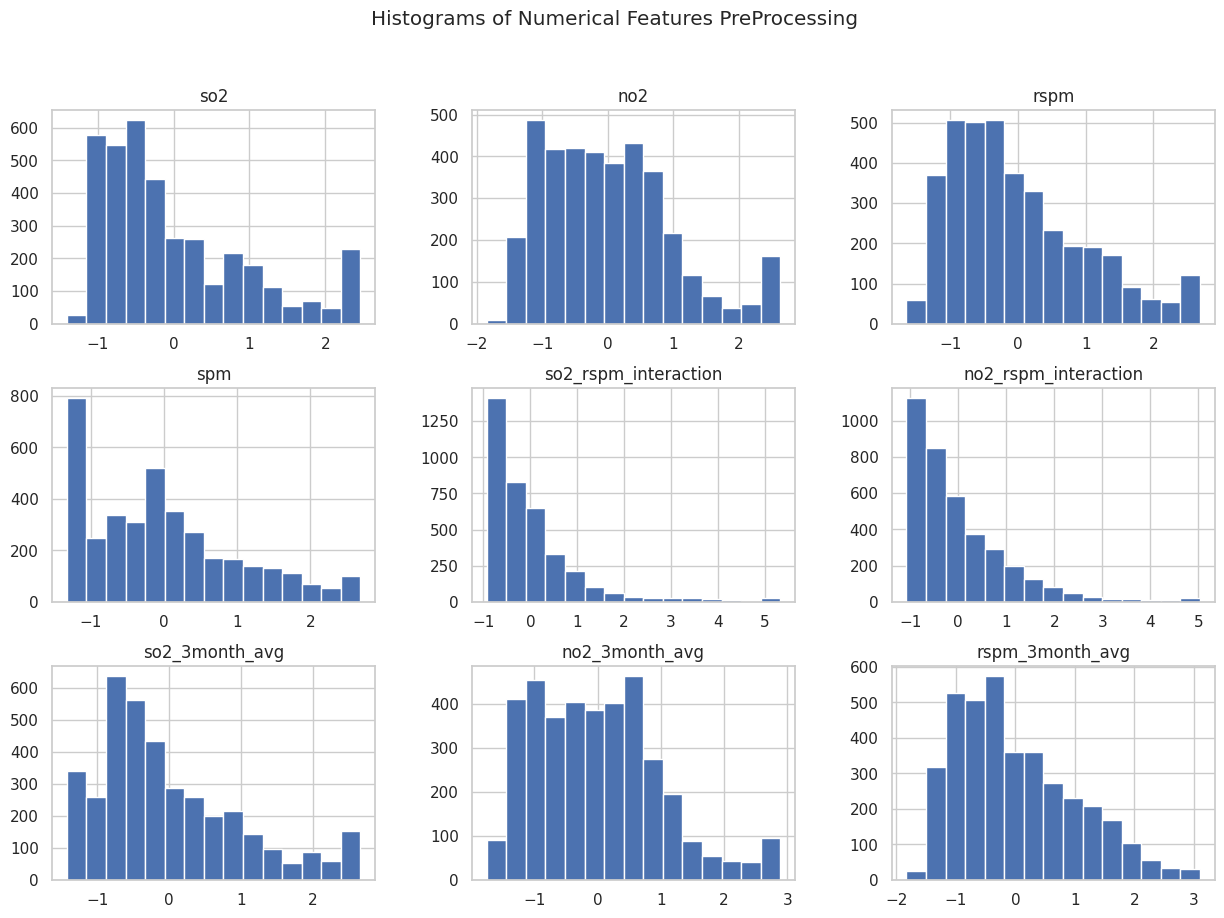

In [456]:
# Histogram for distribution of numerical features
numerical_columns = ['so2', 'no2', 'rspm', 'spm', 'so2_rspm_interaction', 'no2_rspm_interaction',
                     'so2_3month_avg', 'no2_3month_avg', 'rspm_3month_avg']

air_quality[numerical_columns].hist(bins=15, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Features PreProcessing")
plt.show()

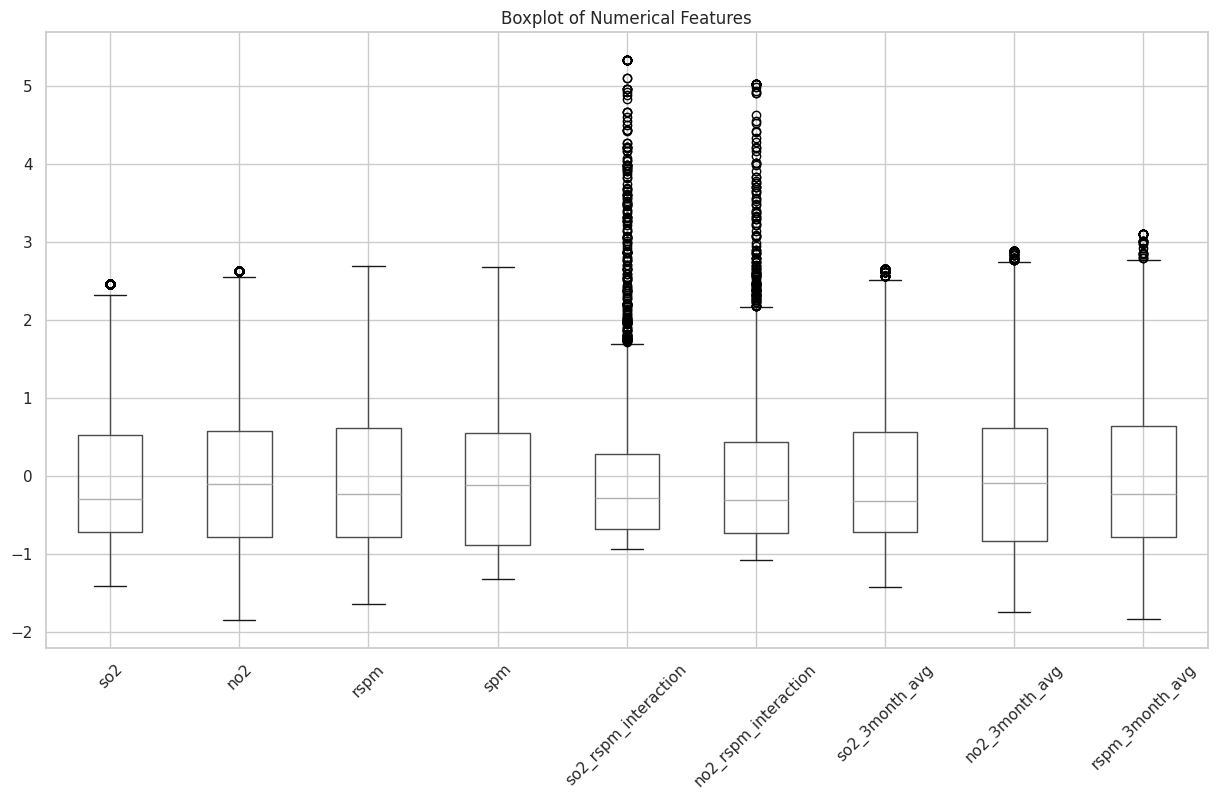

In [457]:
# Boxplot to visualize spread and check for any remaining outliers
plt.figure(figsize=(15, 8))
air_quality[numerical_columns].boxplot(rot=45)
plt.title("Boxplot of Numerical Features")
plt.show()

### Decision to Retain Outliers in Interaction Features

In our data preparation, I chose to handle outliers differently in the original metrics (e.g., so2, no2, rspm, spm) compared to interaction features. Here’s a breakdown of the reasoning behind this approach:

**Foundation of Prediction Accuracy:**

The original metrics serve as the foundational values on which our model will base predictions. Outliers in these base metrics can distort the model's learning, especially for models like LSTM or Transformer that are sensitive to extreme values in time-series data. Removing extreme outliers in these metrics helps stabilize the base signal, enabling the model to better learn underlying trends without being skewed by rare anomalies in the foundational data.

**Real-World Representation in Interaction Terms:**

Interaction features, however, are designed to capture compounded effects and complex relationships between the original metrics. Outliers in interaction terms can reveal high-impact environmental conditions or unique events that might otherwise go unnoticed in the base features alone. By retaining these outliers, I allow the model to capture nuanced, amplified relationships that are critical for forecasting in environmental data.

**Model Robustness and Interpretability:**

In time-series analysis, maintaining a stable and clean foundation in primary metrics, while allowing variability in interaction terms, balances interpretability with robustness. It prevents base metric anomalies from overshadowing general trends while still preserving meaningful variability in higher-order effects.

**Best Practices in Time-Series and Environmental Analysis:**

In predictive modeling, especially with time-series data, it’s common to “clean” foundational features for consistency, while allowing interaction terms to retain real-world variability. This approach aligns with best practices in the field by focusing on clean, interpretable base metrics while ensuring interaction terms can capture complex, compounded behaviors.

By following this approach, I prioritize stable trends in primary metrics and allow interaction terms to reflect real-world conditions. This decision supports model accuracy and interpretability, creating a well-rounded dataset for time-series forecasting.

In [458]:
missing_summ(air_quality)

Series([], dtype: int64)


,0


In [463]:
check(air_quality, 10)

,so2,no2,rspm,spm,location_Alwar,location_Bangalore,location_Chandigarh,location_Coimbatore,location_Damtal,location_Ghaziabad,...,no2_rspm_interaction,year,month,is_winter,is_spring,is_summer,is_autumn,so2_3month_avg,no2_3month_avg,rspm_3month_avg
month,,,,,,,,,,,,,,,,,,,,,
2004-01,-0.163387,-1.166092,0.830764,-1.250973,0,0,0,0,0,0,...,-0.497484,2004,1,1,0,0,0,-0.325431,-1.472931,0.085752
2004-02,-0.440012,-1.393849,-0.503517,-1.273427,0,0,0,0,0,0,...,-0.891267,2004,2,1,0,0,0,-0.325431,-1.472931,0.085752
2004-03,-0.301699,-1.469768,-0.104608,-1.265942,0,0,0,0,0,0,...,-0.863048,2004,3,0,1,0,0,-0.325431,-1.472931,0.085752
2004-04,-0.440012,-1.469768,0.473122,-1.273427,0,0,0,0,0,0,...,-0.782239,2004,4,0,1,0,0,-0.424966,-1.583973,-0.051903
2004-05,-0.578324,-1.317930,0.761987,-1.273427,0,0,0,0,0,0,...,-0.627676,2004,5,0,1,0,0,-0.474733,-1.556212,0.435183
2004-06,-0.578324,-1.469768,-0.173385,-1.273427,0,0,0,0,0,0,...,-0.872668,2004,6,0,0,1,0,-0.574267,-1.556212,0.408711
2004-07,-0.440012,-1.545687,-0.709849,-1.280911,0,0,0,0,0,0,...,-0.970473,2004,7,0,0,1,0,-0.574267,-1.583973,-0.046608
2004-08,0.943113,-1.621606,-0.104608,-1.288396,0,0,0,0,0,0,...,-0.936803,2004,8,0,0,1,0,-0.026829,-1.695014,-0.380156
2004-09,-0.440012,-1.317930,0.390589,-0.906687,0,0,0,0,0,0,...,-0.696941,2004,9,0,0,0,1,0.022938,-1.639493,-0.163085


# 4. Final Dataset Export

In [464]:
# Saving the finalized dataset after EDA to a new CSV file for direct loading in the modeling stage.

air_quality.to_csv('/content/drive/My Drive/Colab Notebooks/air_quality_final.csv', index=True)
print("Finalized dataset saved as 'air_quality_final.csv'")

Finalized dataset saved as 'air_quality_final.csv'
